### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/home/markus/.local/lib/python3.8/site-packages/iotfunctions/bif.py:1878: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [8]:
# setting to make life easier
Temperature='Temperature'
kmeans='TemperatureKmeansScore'
fft='TemperatureFFTScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.3
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 30000



#### What will be shown

General approach is straightforward
* read raw data in
* transform it so that it is compatible to the Monitoring pipeline
* add yet another anomaly detector based on computer vision technology. The point here is to show how to run pipeline anomaly functions 'locally', an important concept for automated testing.
* simplify the dataframe - we have only one entity, no need for an entity index
* render input data and anomaly scores properly scaled

<br>

We start with Microsoft's anomaly test data found here
https://github.com/microsoft/anomalydetector/blob/master/samples/sample.csv

and then proceed to applying anomaly detection to real life pump data


<br>


#### Current inventory of anomaly detectors by type

This is the list of functions to apply


| Detector | ML Type | Type         | How does it work |
| ------- | ------------ | ------- | ---------------- |
| KMeans | Unsupervised | Proximity | Clusters data points in centroid buckets, small buckets are outliers, score is distance to closest other bucket |
| Generalized | Unsupervised | Linear Model | Covariance matrix over data point vectors serves to measure multi-dimensional deviation |
| FFT | Unsupervised | Linear Model | Run FFT before applying Generalized |
| Spectral | Unsupervised | Linear Model | Compute signal energy to reduce dimensions |
| Saliency | Unsupervised | Linear Model | Apply saliency transform (from computer vision |
| SimpleAnomaly | **Supervised** | Ensemble | Run Gradient boosting on training data, anomaly if prediction deviates from actual data |
| --- | **Supervised** | LSTM | Train a stacked LSTM, anomaly if prediction deviates from actual data |



In [3]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./AzureAnomalysample.csv', index_col=False, parse_dates=['timestamp'])

df_i['entity']='MyRoom'
df_i['Temperature']=df_i['value'] + 20
df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

Temperature
entity timestamp                       
MyRoom 2017-10-09 20:32:00         23.0
       2017-10-09 20:33:00         23.0

In [4]:
# Now run the anomaly functions as if they were executed in a pipeline

spsi = SpectralAnomalyScore(Temperature, 12, spectral)
et = spsi._build_entity_type(columns = [Column(Temperature,Float())])
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

sali = SaliencybasedGeneralizedAnomalyScore(Temperature, 12, sal)
et = sali._build_entity_type(columns = [Column(Temperature,Float())])
sali._entity_type = et
df_i = sali.execute(df=df_i)

ffti = FFTbasedGeneralizedAnomalyScore(Temperature, 12, fft)
et = ffti._build_entity_type(columns = [Column(Temperature,Float())])
ffti._entity_type = et
df_i = ffti.execute(df=df_i)

kmi = KMeansAnomalyScore(Temperature, 12, kmeans)
et = kmi._build_entity_type(columns = [Column(Temperature,Float())])
kmi._entity_type = et
df_i = kmi.execute(df=df_i)

df_i.describe()

2020-06-02T12:31:27.910 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T12:31:27.912 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T12:31:28.097 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T12:31:28.098 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T12:31:29.153 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T12:31:29.155 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T12:31:30.257 WARNING iotfunctions.metadat

/home/markus/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


,Temperature,TemperatureSpectralScore,SaliencyAnomalyScore,TemperatureFFTScore,TemperatureKmeansScore
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,24.264336,9.261753,87.978360,87.429128,0.708876
std,1.484244,34.447387,553.359322,353.431728,1.096748
min,20.000000,0.002848,0.651725,0.000000,0.000000
25%,23.062500,4.407648,6.753567,7.962282,0.349280
50%,24.000000,5.321131,15.352148,12.767282,0.446829
75%,25.437500,5.967136,30.350319,18.908024,0.566389
max,30.750000,930.657846,11143.512705,4309.528407,7.304404


In [5]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['MyRoom']]
df_inputm2.reset_index(level=[0], inplace=True)

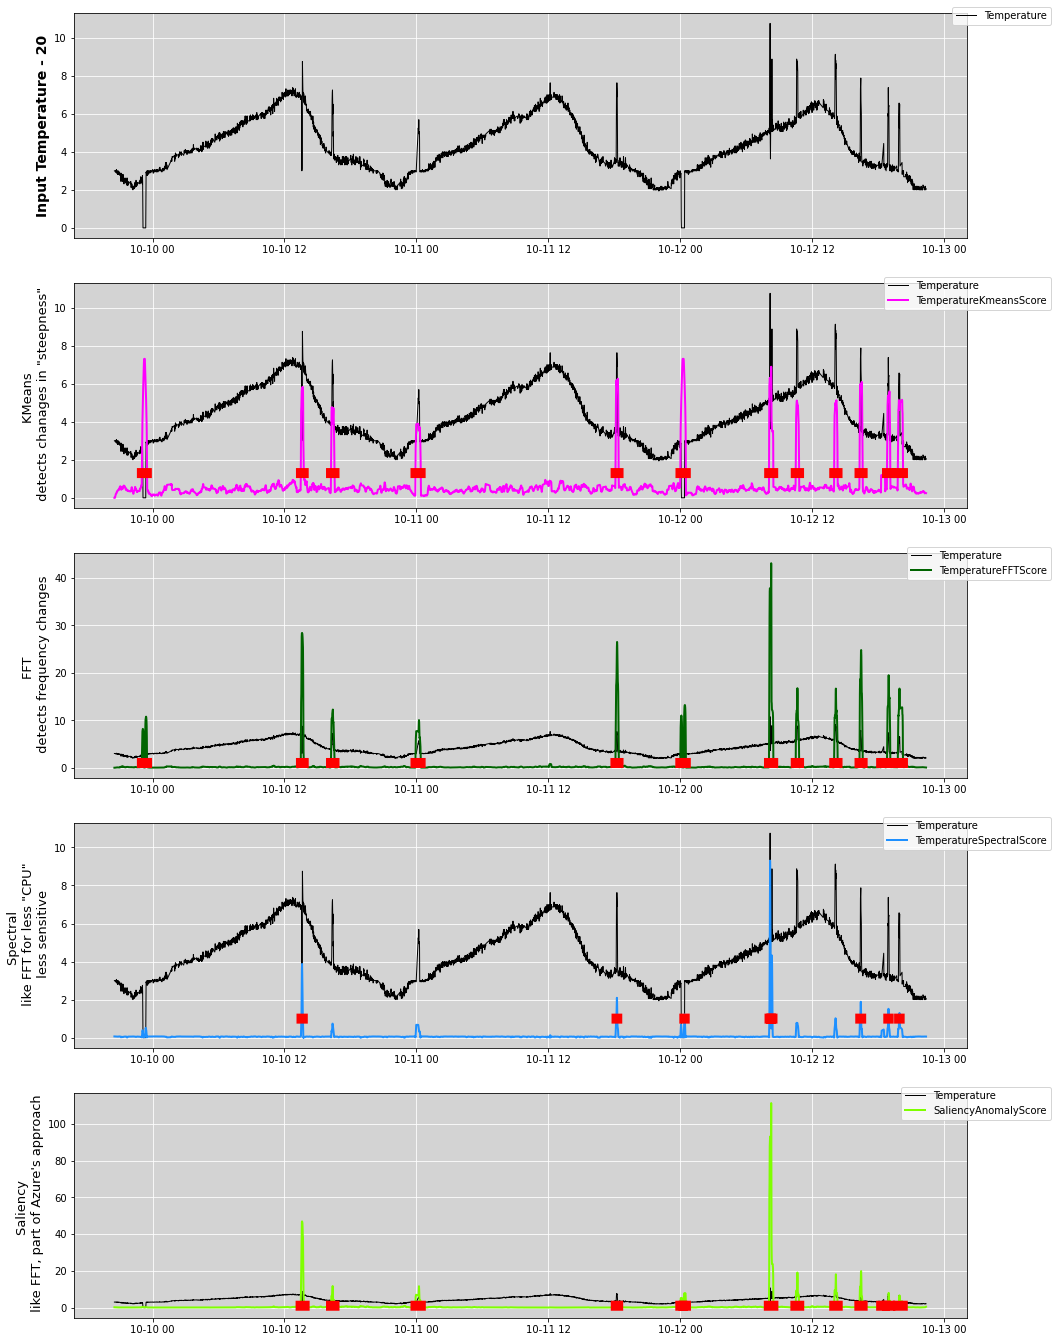

In [9]:
# df_inputm2[spectral].values[df_inputm2[spectral] > 0.001] = 0.001
# df_inputm2[fft].values[df_inputm2[fft] < -1] = -1
df_inputm2[kmeansA] = df_inputm2[kmeans]
df_inputm2[kmeansA].values[df_inputm2[kmeansA] < kmeans_break] = np.nan
df_inputm2[kmeansA].values[df_inputm2[kmeansA] > kmeans_break] = kmeans_break
df_inputm2[kmeansB] = df_inputm2[kmeans]
df_inputm2[kmeansB].values[df_inputm2[kmeansB] >= kmeans_break] = 4
df_inputm2[kmeansB].values[df_inputm2[kmeansB] < kmeans_break] = 3

# Scale spectral and saliency 
# df_inputm2[spectral].values[df_inputm2[spectral] >= spectral_break] = -spectral_break
# df_inputm2[sal].values[df_inputm2[sal] > sal_break] = sal_break



df_inputm2[fftA] = df_inputm2[fft]
df_inputm2[fftA].values[df_inputm2[fftA] < fft_break] = np.nan
df_inputm2[fftA].values[df_inputm2[fftA] > fft_break] = fft_break
df_inputm2[spectralA] = df_inputm2[spectral]
df_inputm2[spectralA].values[df_inputm2[spectralA] < spectral_break] = np.nan
df_inputm2[spectralA].values[df_inputm2[spectralA] > spectral_break] = spectral_break
df_inputm2[salA] = df_inputm2[sal]
df_inputm2[salA].values[df_inputm2[salA] < sal_break] = np.nan
df_inputm2[salA].values[df_inputm2[salA] > sal_break] = sal_break
#df_inputm2[genA] = df_inputm2[gen]
#df_inputm2[genA].values[df_inputm2[genA] < gen_break] = np.nan
#df_inputm2[genA].values[df_inputm2[genA] > gen_break] = gen_break

plots = 5

fig, ax = plt.subplots(plots, 1, figsize=(16,24))
cnt = 0
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input Temperature - 20',fontsize=14,weight="bold")
cnt = 1
#ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Input)
#ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
#ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
#ax[cnt].plot(df_inputm2.index, -df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
#ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
#ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt = 1
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=13)
cnt = 2
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputm2.index, df_inputm2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)
cnt = 3
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectralA]/spectral_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n like FFT for less "CPU"\n less sensitive', fontsize=13)
cnt = 4
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_inputm2.index, df_inputm2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n like FFT, part of Azure\'s approach', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

In [62]:
# any detected anomaly segment should overlap with a real anomaly segment (true positive)
# any detected anomaly segment should overlap with only one 'real' anomaly segment 
#   (otherwise it's a hidden false positive)
# any real anomaly must overlap with a detected anomaly (false negative)

anomalyList_ = [('2017-10-09 23:07:00','2017-10-09 23:23:00'),
                ('2017-10-10 13:35:00','2017-10-10 13:36:00'),
                ('2017-10-10 13:38:00','2017-10-10 13:40:00'),
                ('2017-10-10 16:19:00','2017-10-10 16:27:00'),
                ('2017-10-11 00:10:00','2017-10-11 00:17:00'),
                ('2017-10-11 18:11:00','2017-10-11 18:17:00'),
                ('2017-10-12 00:05:00','2017-10-12 00:23:00'),
                ('2017-10-12 08:09:00','2017-10-12 08:12:00'),
                ('2017-10-12 10:34:00','2017-10-12 10:41:00'),
                ('2017-10-12 14:04:00','2017-10-12 14:11:00'),
                ('2017-10-12 16:22:00','2017-10-12 16:28:00'),
                ('2017-10-12 18:52:00','2017-10-12 18:58:00'),
                ('2017-10-12 19:51:00','2017-10-12 19:58:00')]
anomalyList = []

for a in anomalyList_:
    anomalyList.append((pd.Timestamp(a[0]),pd.Timestamp(a[1])))


def get_anom_list(df, label):
    anomList = np.split(df[label], np.where(np.isnan(df[label].values))[0])
    anomList = [a[~np.isnan(a)] for a in anomList] 
    anomList = [a[~np.isnan(a)] for a in anomList] 
    anomList = [a for a in anomList if not a.empty]
    anomList2 = []
    for a in anomList:
        anomList2.append((a.first('1T').index[0], a.last('1T').index[0]))
    return anomList2

def overlapping_segment(a, b):
    x = max(a[0], b[0])
    y = min(a[1], b[1])
    return x<y

def charact(anomList):
    TP = 0
    FP = 0
    FN = 0

    for i in anomalyList:
        found = False
        for j in anomFFT:
            if overlapping_segment(i,j):
                TP += 1
                found = True
                break
        if not found:
            FN += 1

    for j in anomFFT:
        found = False
        for i in anomalyList:
            if overlapping_segment(i,j):
                found = True
                break
        if not found:
            print(j)
            FP += 1
            
    return TP, FP, FN

    
# split along NaN
anomFFT = get_anom_list(df_inputm2, fftA)

TP, FP, FN = charact(anomFFT)

print ('TP ', TP, ' FP ', FP, ' FN ', FN)

anomKM = get_anom_list(df_inputm2, kmeansA)

TP, FP, FN = charact(anomKM)

print ('TP ', TP, ' FP ', FP, ' FN ', FN)





(Timestamp('2017-10-12 18:16:00'), Timestamp('2017-10-12 18:37:00'))
TP  13  FP  1  FN  0
(Timestamp('2017-10-12 18:16:00'), Timestamp('2017-10-12 18:37:00'))
TP  13  FP  1  FN  0


#### Results

Clear **winners** are 
* **KMeans** and 
* **FFT**.

Spectral is way too sensitive while Saliency 
doesn't detect the negative peak at 10/10 midnight


In [64]:
# need a helper function to convert array columns to something easier
from scipy import linalg
def l2norm(df, tcol, col1, col2 = None, col3 = None):
    l2vib = []
    for index, row in df.iterrows():
        l2vib_element = linalg.norm(np.fromstring(row[col1].replace('[',' ').replace(']',''), sep = ','))**2
        if col2 is not None:
            l2vib_element = l2vib_element + \
                            linalg.norm(np.fromstring(row[col2].replace('[',' ').replace(']',''), sep = ','))**2
        if col3 is not None:
            l2vib_element = l2vib_element + \
                            linalg.norm(np.fromstring(row[col3].replace('[',' ').replace(']',''), sep = ','))**2
        l2vib.append(l2vib_element**(1/2))
    df[tcol] = np.asarray(l2vib)
    

def unrollAccel(df):
    l0,l1,l2,l3,l4=[],[],[],[],[]
    for i in df['ACCEL_POWER'].values:
        l0.append(eval(eval(i)[0]))
        l1.append(eval(eval(i)[1]))
        l2.append(eval(eval(i)[2]))
        l3.append(eval(eval(i)[3]))
        l4.append(eval(eval(i)[4]))
    df['accel_power_0'] = np.asarray(l0)
    df['accel_power_1'] = np.asarray(l1)
    df['accel_power_2'] = np.asarray(l2)
    df['accel_power_3'] = np.asarray(l3)
    df['accel_power_4'] = np.asarray(l4)
    
listAttr = ['timestamp','entity','vibrations','rms','accel_speed','accel_power_0','accel_power_1',
            'accel_power_2','accel_power_3','accel_power_4']

In [65]:
# Now we proceed to customer data - GOOD CASE

# Get stuff in
df_input_raw = pd.read_csv('./Armstark04714B6046D5.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_input_raw['entity']=df_input_raw['DEVICE_ID']
df_input_raw['timestamp']=df_input_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_input_raw = df_input_raw.sort_values(by='timestamp')
df_input_raw = df_input_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_input_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_input_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_input_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_input_raw)
#l2norm(df_input_raw, 'accel_power', 'ACCEL_POWER')

df_input = df_input_raw.filter(listAttr, axis=1)
df_input_raw.describe()

<ipython-input-64-80608205ccaa>:6: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  l2vib_element = linalg.norm(np.fromstring(row[col1].replace('[',' ').replace(']',''), sep = ','))**2
<ipython-input-64-80608205ccaa>:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  linalg.norm(np.fromstring(row[col2].replace('[',' ').replace(']',''), sep = ','))**2
<ipython-input-64-80608205ccaa>:12: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  linalg.norm(np.fromstring(row[col3].replace('[',' ').replace(']',''), sep = ','))**2


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
count,8620.000000,8.620000e+03,8620.0,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,1.732051e+00,1.0,2.453523,2.453312,2.452808,2.452053,2.452439
std,0.033272,4.441150e-16,0.0,0.856247,0.857594,0.857678,0.857200,0.856340
min,3.616515,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.737696,1.732051e+00,1.0,2.251800,2.251800,2.252000,2.252000,2.251800
50%,3.757949,1.732051e+00,1.0,2.313800,2.313400,2.311800,2.312200,2.312600
75%,3.780154,1.732051e+00,1.0,2.691450,2.692100,2.685100,2.681850,2.682300
max,3.898555,1.732051e+00,1.0,5.325799,5.293200,5.334001,5.278600,5.282000


In [66]:
# Run Monitoring's anomaly detector functions

salii = SaliencybasedGeneralizedAnomalyScore('vibrations', 12, 'SaliencyVibrationScore')
et = salii._build_entity_type(columns = [Column('vibrations',Float())])
salii._entity_type = et
df_input = salii.execute(df=df_input)


spsii = SpectralAnomalyScore('vibrations', 12, 'SpectralVibrationScore')
et = spsii._build_entity_type(columns = [Column('vibrations',Float())])
spsii._entity_type = et
df_input = spsii.execute(df=df_input)

kmii = KMeansAnomalyScore('vibrations', 12, 'KMeansVibrationScore')
et = kmii._build_entity_type(columns = [Column('vibrations',Float())])
kmii._entity_type = et
df_input = kmii.execute(df=df_input)

fftii = FFTbasedGeneralizedAnomalyScore('vibrations', 12, 'FFTVibrationScore')
et = fftii._build_entity_type(columns = [Column('vibrations',Float())])
fftii._entity_type = et
df_input = fftii.execute(df=df_input)

df_input.describe()

2020-06-02T14:07:50.781 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:07:50.782 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T14:07:52.442 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:07:52.443 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T14:07:52.760 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:07:52.761 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


/home/markus/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


2020-06-02T14:07:57.854 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:07:57.854 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
count,8620.000000,8.620000e+03,8620.0,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,1.732051e+00,1.0,2.453523,2.453312,2.452808,2.452053,2.452439,17.785380,25.259561,0.087914,13.626316
std,0.033272,4.441150e-16,0.0,0.856247,0.857594,0.857678,0.857200,0.856340,14.486994,25.227880,0.025500,7.899369
min,3.616515,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.356699,0.005063,0.022573,0.771379
25%,3.737696,1.732051e+00,1.0,2.251800,2.251800,2.252000,2.252000,2.251800,5.833554,10.339797,0.071338,8.418707
50%,3.757949,1.732051e+00,1.0,2.313800,2.313400,2.311800,2.312200,2.312600,14.630254,20.552395,0.085002,12.017826
75%,3.780154,1.732051e+00,1.0,2.691450,2.692100,2.685100,2.681850,2.682300,26.112277,32.141765,0.101584,17.253135
max,3.898555,1.732051e+00,1.0,5.325799,5.293200,5.334001,5.278600,5.282000,98.672447,302.745841,0.217574,63.261967


In [67]:
EngineLogging.configure_console_logging(logging.INFO)

df_input2 = df_input.loc[['04714B6046D5']]
df_input2.reset_index(level=[0], inplace=True)

# redefine
# setting to make life easier
Temperature='vibrations'
kmeans='KMeansVibrationScore'
fft='FFTVibrationScore'
spectral='SpectralVibrationScore'
sal='SaliencyVibrationScore'
#gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.3
spectral_break = 2.8
fft_break = 100
sal_break = 100
gen_break = 30000

df_input2

,entity,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
timestamp,,,,,,,,,,,,,
2020-01-01 00:02:25.928,04714B6046D5,3.787826,1.732051,1.0,2.2904,2.2824,2.2858,2.2956,2.3278,9.955894,34.626486,0.107194,6.657871
2020-01-01 00:07:26.074,04714B6046D5,3.776503,1.732051,1.0,2.2822,2.2978,2.2966,2.3504,2.3190,9.036381,32.208784,0.100376,6.755634
2020-01-01 00:12:25.663,04714B6046D5,3.715573,1.732051,1.0,2.2718,2.2908,2.2912,2.3044,2.3232,8.116868,29.791082,0.093557,6.853397
2020-01-01 00:17:26.020,04714B6046D5,3.765538,1.732051,1.0,2.2748,2.2932,2.2926,2.3146,2.3606,7.197354,27.373380,0.086738,6.951160
2020-01-01 00:22:25.727,04714B6046D5,3.725934,1.732051,1.0,2.3320,2.2980,2.2998,2.3212,2.2860,6.277841,24.955677,0.079920,7.048923
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 11:39:23.476,04714B6046D5,3.725156,1.732051,1.0,2.2778,2.2798,2.2676,2.2718,2.2668,7.662554,8.877056,0.100228,16.899648
2020-01-31 11:44:23.497,04714B6046D5,3.766786,1.732051,1.0,2.2734,2.2704,2.2694,2.2728,2.2670,7.307044,7.748011,0.087977,15.013700
2020-01-31 11:49:23.443,04714B6046D5,3.737750,1.732051,1.0,2.2666,2.2714,2.2712,2.2690,2.2646,6.951534,6.618966,0.075727,13.127752


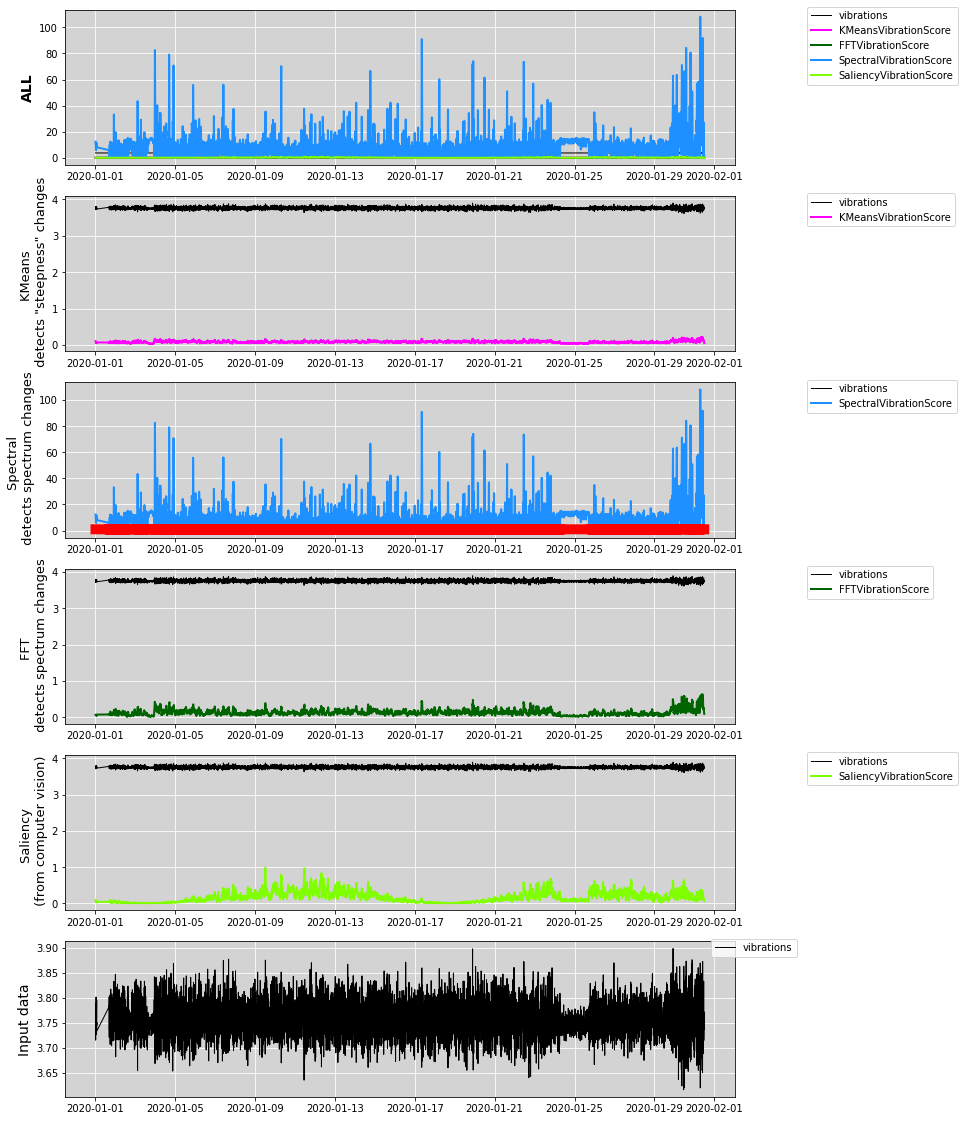

In [68]:
# df_input2[spectral].values[df_input2[spectral] > 0.001] = 0.001
df_input2[fft].values[df_input2[fft] < -1] = -1
df_input2[kmeansA] = df_input2[kmeans]
df_input2[kmeansA].values[df_input2[kmeansA] < kmeans_break] = np.nan
df_input2[kmeansA].values[df_input2[kmeansA] > kmeans_break] = kmeans_break
df_input2[kmeansB] = df_input2[kmeans]
df_input2[kmeansB].values[df_input2[kmeansB] >= kmeans_break] = 4
df_input2[kmeansB].values[df_input2[kmeansB] < kmeans_break] = 3



df_input2[fftA] = df_input2[fft]
df_input2[fftA].values[df_input2[fftA] < fft_break] = np.nan
df_input2[fftA].values[df_input2[fftA] > fft_break] = fft_break
df_input2[spectralA] = df_input2[spectral]
df_input2[spectralA].values[df_input2[spectralA] < spectral_break] = np.nan
df_input2[spectralA].values[df_input2[spectralA] > spectral_break] = spectral_break
df_input2[salA] = df_input2[sal]
df_input2[salA].values[df_input2[salA] < sal_break] = np.nan
df_input2[salA].values[df_input2[salA] > sal_break] = sal_break
#df_input2[genA] = df_input2[gen]
#df_input2[genA].values[df_input2[genA] < gen_break] = np.nan
#df_input2[genA].values[df_input2[genA] > gen_break] = gen_break

plots = 6

fig, ax = plt.subplots(plots, 1, figsize=(12,20))
cnt = 0
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_input2.index, df_input2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_input2.index, df_input2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_input2.index, df_input2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[0].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet',label=gen)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt=1
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[kmeans], linewidth=2, color='magenta',label=kmeans)
#ax[cnt].plot(df_input2.index, df_input2[kmeansB], linewidth=2, color='yellow') #label=kmeans)
ax[cnt].plot(df_input2.index, df_input2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects "steepness" changes',fontsize=13)
cnt=2
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_input2.index, df_input2[spectralA]/spectral_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n detects spectrum changes', fontsize=13)
cnt=3
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_input2.index, df_input2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects spectrum changes', fontsize=13)
cnt=4
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_input2.index, df_input2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n (from computer vision)', fontsize=13)
cnt=5
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
#ax[cnt].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet', label=gen)
#ax[cnt].plot(df_input2.index, df_input2[genA]/gen_break, linewidth=10, color='red')
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input data', fontsize=14)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

#ax.set_ylabel('Temperature-50')

In [69]:
# Now we proceed to customer data - BAD CASE

# Get stuff in
df_inputb_raw = pd.read_csv('./Armstark04714B604101.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_inputb_raw['entity']=df_inputb_raw['DEVICE_ID']
df_inputb_raw['timestamp']=df_inputb_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_inputb_raw = df_inputb_raw.sort_values(by='timestamp')
df_inputb_raw = df_inputb_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_inputb_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_inputb_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_inputb_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_inputb_raw)
#l2norm(df_inputb, 'accel_power', 'ACCEL_POWER')

df_inputb = df_inputb_raw.filter(listAttr, axis=1)
df_inputb.head(5)

<ipython-input-64-80608205ccaa>:6: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  l2vib_element = linalg.norm(np.fromstring(row[col1].replace('[',' ').replace(']',''), sep = ','))**2
<ipython-input-64-80608205ccaa>:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  linalg.norm(np.fromstring(row[col2].replace('[',' ').replace(']',''), sep = ','))**2
<ipython-input-64-80608205ccaa>:12: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  linalg.norm(np.fromstring(row[col3].replace('[',' ').replace(']',''), sep = ','))**2


vibrations       rms  accel_speed  \
entity       timestamp                                                    
04714B604101 2020-01-01 00:02:12.713    3.718562  1.732051          1.0   
             2020-01-01 00:07:12.739    3.786815  1.732051          1.0   
             2020-01-01 00:12:12.769    3.653347  1.732051          1.0   
             2020-01-01 00:17:12.806    3.673086  1.732051          1.0   
             2020-01-01 00:22:13.071    3.754269  1.732051          1.0   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B604101 2020-01-01 00:02:12.713         2.3650         2.3388   
             2020-01-01 00:07:12.739         2.5250         2.3846   
             2020-01-01 00:12:12.769         2.5186         2.3766   
             2020-01-01 00:17:12.806         2.4960         2.3822   
             2020-01-01 00:22:13.071         2.5404         2.3874   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B604101 2020-01-01 00:02:12.713         2.3410         2.3578   
             2020-01-01 00:07:12.739         2.3978         2.3980   
             2020-01-01 00:12:12.769         2.3606         2.4578   
             2020-01-01 00:17:12.806         2.3832         2.4854   
             2020-01-01 00:22:13.071         2.3896         2.4240   

                                      accel_power_4  
entity       timestamp                               
04714B604101 2020-01-01 00:02:12.713         2.5272  
             2020-01-01 00:07:12.739         2.5762  
             2020-01-01 00:12:12.769         2.5150  
             2020-01-01 00:17:12.806         2.3844  
             2020-01-01 00:22:13.071         2.4112

In [70]:
# Again run Monitoring's anomaly detector functions

salii = SaliencybasedGeneralizedAnomalyScore('vibrations', 12, 'SaliencyVibrationScore')
et = salii._build_entity_type(columns = [Column('vibrations',Float())])
salii._entity_type = et
df_inputb = salii.execute(df=df_inputb)


spsii = SpectralAnomalyScore('vibrations', 12, 'SpectralVibrationScore')
et = spsii._build_entity_type(columns = [Column('vibrations',Float())])
spsii._entity_type = et
df_inputb = spsii.execute(df=df_inputb)

kmii = KMeansAnomalyScore('vibrations', 12, 'KMeansVibrationScore')
et = kmii._build_entity_type(columns = [Column('vibrations',Float())])
kmii._entity_type = et
df_inputb = kmii.execute(df=df_inputb)

fftii = FFTbasedGeneralizedAnomalyScore('vibrations', 12, 'FFTVibrationScore')
et = fftii._build_entity_type(columns = [Column('vibrations',Float())])
fftii._entity_type = et
df_inputb = fftii.execute(df=df_inputb)

df_inputb.describe()

2020-06-02T14:08:05.892 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:08:05.892 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T14:08:07.680 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:08:07.681 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T14:08:08.010 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:08:08.011 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


/home/markus/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


2020-06-02T14:08:13.438 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:08:13.439 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
count,8613.000000,8.613000e+03,8613.0,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000
mean,3.714736,1.732051e+00,1.0,2.408757,2.409634,2.407835,2.408529,2.409018,26.090731,24.513694,0.219358,25.391862
std,0.088517,4.441150e-16,0.0,0.947978,0.948468,0.947572,0.947615,0.947830,29.013612,26.481873,0.108551,24.427227
min,3.299344,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.681661,0.000871,0.000000,0.628891
25%,3.664859,1.732051e+00,1.0,2.268600,2.268400,2.268400,2.268000,2.268600,5.917995,11.303480,0.152590,8.708731
50%,3.701923,1.732051e+00,1.0,2.352200,2.351000,2.349600,2.351600,2.352400,15.897024,19.858287,0.195482,15.403029
75%,3.758416,1.732051e+00,1.0,2.666400,2.685000,2.670600,2.671000,2.675600,33.643744,27.489775,0.285913,37.312574
max,4.221860,1.732051e+00,1.0,5.060000,4.975000,4.883400,5.401600,5.238200,225.329508,324.204142,0.645313,155.118957


In [71]:
EngineLogging.configure_console_logging(logging.INFO)

df_inputb2 = df_inputb.loc[['04714B604101']]
df_inputb2.reset_index(level=[0], inplace=True)

# redefine
# setting to make life easier
Temperature='vibrations'
kmeans='KMeansVibrationScore'
fft='FFTVibrationScore'
spectral='SpectralVibrationScore'
sal='SaliencyVibrationScore'
#gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.3
spectral_break = 2.8
fft_break = 100
sal_break = 100
gen_break = 30000

df_inputb2


,entity,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
timestamp,,,,,,,,,,,,,
2020-01-01 00:02:12.713,04714B604101,3.718562,1.732051,1.0,2.3650,2.3388,2.3410,2.3578,2.5272,2.799900,16.799369,0.000000,4.585095
2020-01-01 00:07:12.739,04714B604101,3.786815,1.732051,1.0,2.5250,2.3846,2.3978,2.3980,2.5762,3.258814,15.137877,0.000000,5.662873
2020-01-01 00:12:12.769,04714B604101,3.653347,1.732051,1.0,2.5186,2.3766,2.3606,2.4578,2.5150,3.717728,13.476384,0.000000,6.740650
2020-01-01 00:17:12.806,04714B604101,3.673086,1.732051,1.0,2.4960,2.3822,2.3832,2.4854,2.3844,4.176642,11.814892,0.007647,7.818428
2020-01-01 00:22:13.071,04714B604101,3.754269,1.732051,1.0,2.5404,2.3874,2.3896,2.4240,2.4112,4.635557,10.153400,0.050038,8.896205
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 11:36:16.066,04714B604101,3.670139,1.732051,1.0,2.2880,2.2846,2.2898,2.2878,2.2852,16.980818,152.683720,0.351833,58.467311
2020-01-31 11:41:15.841,04714B604101,3.893611,1.732051,1.0,2.2808,2.2876,2.2852,2.2712,2.2704,16.694134,184.303852,0.372674,59.187724
2020-01-31 11:46:16.049,04714B604101,3.660626,1.732051,1.0,2.2820,2.2724,2.2700,2.2682,2.2706,16.407449,215.923985,0.393515,59.908137


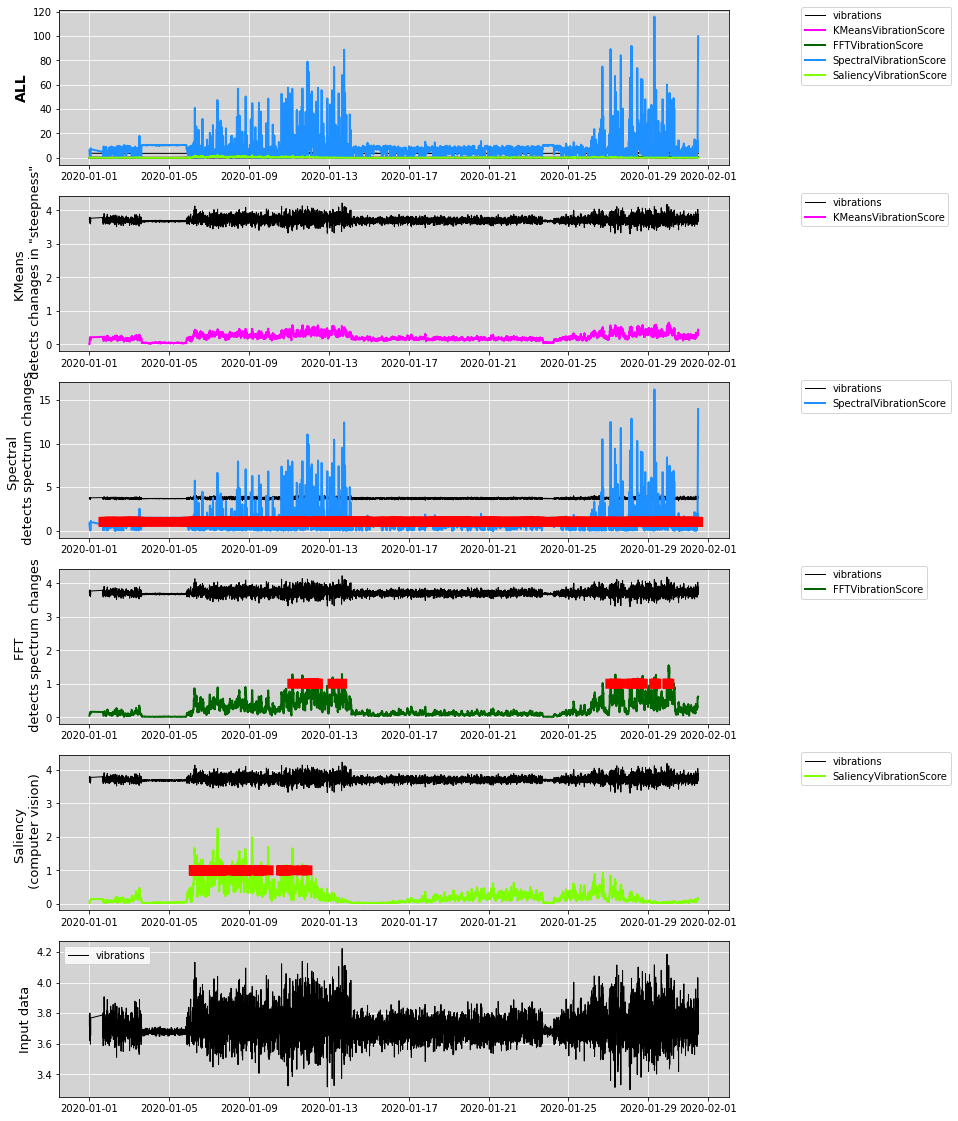

In [72]:
#df_inputb2[spectral].values[df_inputb2[spectral] > 0.001] = 0.001
df_inputb2[fft].values[df_inputb2[fft] < -1] = -1
df_inputb2[kmeansA] = df_inputb2[kmeans]
df_inputb2[kmeansA].values[df_inputb2[kmeansA] < kmeans_break] = np.nan
df_inputb2[kmeansA].values[df_inputb2[kmeansA] > kmeans_break] = kmeans_break
df_inputb2[kmeansB] = df_inputb2[kmeans]
df_inputb2[kmeansB].values[df_inputb2[kmeansB] >= kmeans_break] = 4
df_inputb2[kmeansB].values[df_inputb2[kmeansB] < kmeans_break] = 3



df_inputb2[fftA] = df_inputb2[fft]
df_inputb2[fftA].values[df_inputb2[fftA] < fft_break] = np.nan
df_inputb2[fftA].values[df_inputb2[fftA] > fft_break] = fft_break
df_inputb2[spectralA] = df_inputb2[spectral]
df_inputb2[spectralA].values[df_inputb2[spectralA] < 20] = np.nan
df_inputb2[spectralA].values[df_inputb2[spectralA] > 20] = 20
df_inputb2[salA] = df_inputb2[sal]
df_inputb2[salA].values[df_inputb2[salA] < sal_break] = np.nan
df_inputb2[salA].values[df_inputb2[salA] > sal_break] = sal_break
#df_input2[genA] = df_input2[gen]
#df_input2[genA].values[df_input2[genA] < gen_break] = np.nan
#df_input2[genA].values[df_input2[genA] > gen_break] = gen_break

plots = 6

fig, ax = plt.subplots(plots, 1, figsize=(12,20))
cnt=0
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputb2.index, df_inputb2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputb2.index, df_inputb2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputb2.index, df_inputb2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[cnt].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet',label=gen)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt=1
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputb2.index, df_inputb2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=13)
cnt=2
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[spectral]/20, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputb2.index, df_inputb2[spectralA]/20, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n detects spectrum changes', fontsize=13)
cnt=3
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputb2.index, df_inputb2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects spectrum changes', fontsize=13)
cnt=4
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_inputb2.index, df_inputb2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n (computer vision)', fontsize=13)
cnt=5
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
#ax[cnt].plot(df_inputb2.index, df_inputb2[gen]/gen_break, linewidth=2,color='darkviolet', label=gen)
#ax[cnt].plot(df_inputb2.index, df_inputb2[genA]/gen_break, linewidth=10, color='red')
ax[cnt].legend()#bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input data', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')


#ax.set_ylabel('Temperature-50')

2020-06-02T14:12:36.344 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


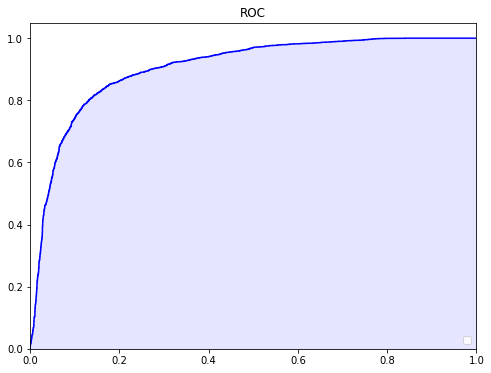

In [82]:
# ROC curve FFT
from sklearn.metrics import roc_curve, auc, roc_auc_score

# before anomaly "negatives"
before_anomaly1 = dt.datetime(2020,1,7,0,0,0)  # before anomaly "negatives"
after_anomaly1 = dt.datetime(2020,1,14,0,0,0)  
before_anomaly2 = dt.datetime(2020,1,27,0,0,0) 
after_anomaly2 = dt.datetime(2020,1,31,0,0,0)

df_inputb2.loc[df_inputb2.index < before_anomaly1,'actual'] = 0
df_inputb2.loc[(df_inputb2.index > before_anomaly1) &
           (df_inputb2.index < after_anomaly1),'actual'] = 1
df_inputb2.loc[(df_inputb2.index > after_anomaly1) &
           (df_inputb2.index < before_anomaly2),'actual'] = 0
df_inputb2.loc[(df_inputb2.index > before_anomaly2) &
           (df_inputb2.index < after_anomaly2),'actual'] = 1
df_inputb2.loc[(df_inputb2.index > after_anomaly2),'actual'] = 0


yyy_test = df_inputb2['actual'].values

np_range = np.arange(0, 151, 1)
score_list = []
fpr_list = []
tpr_list = []
roc_auc_list = []
for ths in np_range:
    yyy_score_ = (np.greater(df_inputb2[fft], ths) | np.greater(df_inputb2[sal], ths)).astype(int)
    score_list.append(yyy_score_)
    fpr_, tpr_, _ = roc_curve(yyy_test, yyy_score_)
    fpr_list.append(fpr_)
    tpr_list.append(tpr_)
    roc_auc_list.append(auc(fpr_,tpr_))

    
yy_score = np.asarray(score_list)
fpr = np.asarray(fpr_list)
tpr = np.asarray(tpr_list)
roc_auc = np.asarray(roc_auc_list)

yyF_score = np.maximum(df_inputb2[fft].values, df_inputb2[sal].values)
fprF, tprF, _ = roc_curve(yyy_test, yyF_score/200)
roc_aucF = auc(fprF, tprF)


fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(fprF, tprF, color='blue', lw=1.5)
ax.fill_between(fprF, tprF, y2=0, color='blue', alpha=0.1)
#ax.plot(fpr[20], tpr[20], color='red',lw=1, label='ROC curve 20 (area = %0.2f)' % roc_auc[20])
#ax.plot(fpr[30], tpr[30], color='turquoise',lw=1, label='ROC curve 30 (area = %0.2f)' % roc_auc[30])
#ax.plot(fpr[50], tpr[50], color='orange',lw=1, label='ROC curve 50 (area = %0.2f)' % roc_auc[50])
#ax.plot(fpr[75], tpr[75], color='violet',lw=1, label='ROC curve 75 (area = %0.2f)' % roc_auc[75])
#ax.plot(fpr[100], tpr[100], color='green',lw=1, label='ROC curve 100 (area = %0.2f)' % roc_auc[100])
#ax.plot(fpr[150], tpr[150], color='red',lw=1, label='ROC curve 150 (area = %0.2f)' % roc_auc[150])
#ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate - lower is better, higher means false alerts')
#plt.ylabel('True Positive Rate - higher is better, we detect more anomalies')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
